# WiFI CSI CNN accuracy comparison with and without phase data.

## Continuation with significantly more data/complex model

To run this code on your own device you need to download 'consolidatited_data.csv' from the onedrive.

In [1]:
%reset -f

import pandas as pd

# Load the DataFrame from a CSV file
df = pd.read_csv('consolidated_data.csv')

# Get unique classes from the last column
unique_classes = df.iloc[:, -1].unique()

# Initialize an empty list to store sampled DataFrames
sampled_dfs = []

# Sample 50,000 rows for each unique class
for unique_class in unique_classes:
    sampled_df = df[df.iloc[:, -1] == unique_class].sample(n=50000, random_state=1)
    sampled_dfs.append(sampled_df)
    print(f"Number of samples in class '{unique_class}': {len(sampled_df)}")

# Concatenate all sampled DataFrames
result_df = pd.concat(sampled_dfs)

# Save the sampled DataFrame to a new CSV file
result_df.to_csv('sampled_data_complex.csv', index=False)

print("Sampled DataFrame saved to 'sampled_data_complex.csv'.")

Number of samples in class 'kneel': 50000
Number of samples in class 'liedown': 50000
Number of samples in class 'pickup': 50000
Number of samples in class 'sit': 50000
Number of samples in class 'sitrotate': 50000
Number of samples in class 'stand': 50000
Number of samples in class 'standrotate': 50000
Number of samples in class 'walk': 50000
Sampled DataFrame saved to 'sampled_data_complex.csv'.


### Preprocessing
Here I load a dataset I made from the original data. It contains 50K samples from each unique target class.

Firstly In this I am removing all of the imaginary components of the data then I am Preprocessing via scaling and encoding.

In [2]:
import pandas as pd
import re

# Function to extract the real component from complex number strings
def extract_real_part(s):
    if isinstance(s, str):
        # Use a regular expression to isolate the real part of numbers possibly in scientific notation
        match = re.search(r'([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)[+-]', s)
        if match:
            return float(match.group(1))  # Return the real part found before the '+-' of the imaginary part
        return s  # Return the original string if no match
    return s  # Return unchanged if not a string

# Function to extract real and imaginary parts from complex number strings
def extract_components(s):
    if isinstance(s, str):
        # Use a regular expression to find real and imaginary parts
        match = re.search(r'([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)([+-]\d*\.?\d+(?:[eE][+-]?\d+)?)i', s)
        if match:
            # Extract real and imaginary parts
            real_part = float(match.group(1))
            imaginary_part = float(match.group(2).replace('i', ''))
            return real_part, imaginary_part
        return None  # If no complex number format is found
    return None  # Return None if input is not a string

# Load the CSV file
df = pd.read_csv('sampled_data_complex.csv')

# Apply the extract_real_part function to each element in the DataFrame except the last column
real_df = df.copy()
for column in real_df.columns[:-1]:  # Exclude the last column
    real_df[column] = real_df[column].apply(extract_real_part)

# Save the modified DataFrame with real parts back to a CSV file
real_df.to_csv('sampled_data_real.csv', index=False)
print("Real parts extraction complete.")

# Prepare new DataFrame to store real and imaginary parts
new_columns = {}
for column in df.columns[:-1]:  # Exclude the last column
    # Apply the extract_components function to each element in the column
    extracted = df[column].apply(extract_components)
    real_part = extracted.apply(lambda x: x[0] if x else None)
    imaginary_part = extracted.apply(lambda x: x[1] if x else None)
    new_columns[f"{column}_real"] = real_part
    new_columns[f"{column}_imag"] = imaginary_part

# Include the last column as is in the new DataFrame
new_columns[df.columns[-1]] = df[df.columns[-1]]

# Create a new DataFrame from the processed columns
new_df = pd.DataFrame(new_columns)

# Save the modified DataFrame with real and imaginary parts back to a CSV file
new_df.to_csv('sampled_data_real_imag.csv', index=False)
print("Real and imaginary parts extraction complete.")

Real parts extraction complete.
Real and imaginary parts extraction complete.


In [3]:
%reset -f

import pandas as pd
from sklearn.preprocessing import StandardScaler

def process_data(df, target_column):
    # Feature Scaling
    scaler = StandardScaler()
    features = df.columns[:-1]
    df[features] = scaler.fit_transform(df[features])
    
    # One-hot encode the target
    df_encoded = pd.get_dummies(df, columns=[target_column])
    
    return df_encoded

# Load the data
df_real = pd.read_csv('sampled_data_real.csv')
df_complex = pd.read_csv('sampled_data_real_imag.csv')

# Process the data
df_encoded_real = process_data(df_real, 'activity')
df_encoded_complex = process_data(df_complex, 'activity')

# Check the transformed data
print(f'Real Numbers: {df_encoded_real.shape}')
print(f'Complex Numbers: {df_encoded_complex.shape}')

Real Numbers: (400000, 98)
Complex Numbers: (400000, 188)


### PCA 
For the PCA, I picked to do it to 8 principle components as I found it captured over 90% of the variance, which is more than sufficient for proving my point of it being worth including the phase data (an imaginary component of phase).

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(df_encoded, target_prefix, n_components=8):
    # Feature Scaling
    scaler = StandardScaler()
    # Extract numerical feature columns (excluding the newly created one-hot encoded columns)
    features = df_encoded.columns.difference(df_encoded.filter(regex=f'{target_prefix}_').columns)
    df_encoded[features] = scaler.fit_transform(df_encoded[features])
    
    # Initialize PCA and specify the number of components
    pca = PCA(n_components=n_components)
    
    # Apply PCA to the features only, excluding the one-hot encoded target columns
    principal_components = pca.fit_transform(df_encoded[features])
    
    # Create a DataFrame for the principal components
    df_pca = pd.DataFrame(data=principal_components, columns=['PC{}'.format(i) for i in range(1, n_components + 1)])
    
    # Concatenate the principal components with the one-hot encoded target columns
    activity_columns = df_encoded.filter(regex=f'{target_prefix}_').columns
    df_pca = pd.concat([df_pca, df_encoded[activity_columns].reset_index(drop=True)], axis=1)
    
    # Print the variance ratio of the principal components
    print(f"Variance captured by the first {n_components} PCA components:")
    print(pca.explained_variance_ratio_)
    
    # Calculate and print the total variance captured by the components
    total_variance = sum(pca.explained_variance_ratio_)
    print(f"Total variance captured by the first {n_components} components:", total_variance)
    
    return df_pca

# Example usage:

# Assuming df_encoded_real and df_encoded_complex are your encoded DataFrames
df_encoded_real = pd.read_csv('sampled_data_real.csv')
df_encoded_complex = pd.read_csv('sampled_data_real_imag.csv')

# Process the data
df_encoded_real = process_data(df_encoded_real, 'activity')
df_encoded_complex = process_data(df_encoded_complex, 'activity')

# Apply PCA
df_pca_real = apply_pca(df_encoded_real, 'activity')
df_pca_complex = apply_pca(df_encoded_complex, 'activity')

# Optionally, save or display the new DataFrames
print(df_pca_real.head())
print(df_pca_complex.head())

Variance captured by the first 8 PCA components:
[0.32382596 0.2441654  0.20823673 0.06110542 0.05214282 0.03772225
 0.02269575 0.01526271]
Total variance captured by the first 8 components: 0.9651570311987732
Variance captured by the first 8 PCA components:
[0.1852744  0.18429185 0.12783617 0.12766863 0.10487091 0.1040448
 0.03236699 0.0322904 ]
Total variance captured by the first 8 components: 0.8986441621027639
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.610171 -0.095464 -3.385700 -6.408013 -0.731977  1.219389 -1.179824   
1  8.136881  2.569684  8.003322  3.923944 -0.959742 -2.721937  3.035132   
2 -2.588638 -5.447510 -0.569359 -1.549124  3.227227  0.584542 -2.152607   
3 -4.401847 -3.373560 -1.174525 -1.036320  3.071207  0.102755 -2.556245   
4  2.328096  4.895200  3.610802  0.729790 -3.109395 -2.036543 -0.047256   

        PC8  activity_kneel  activity_liedown  activity_pickup  activity_sit  \
0 -0.439988            True             False     

# Model Set up
I set up a CCN model on the PCA data, having it run until it stops improving or begins overfitting.

In [5]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

def train_conv1d_model(df_pca, target_column_pattern, patience, batch_size, epochs):
    # Identify feature columns (principal components) and target columns
    feature_columns = [col for col in df_pca if col.startswith('PC')]
    target_columns = df_pca.filter(regex=target_column_pattern).columns

    # Prepare data for model input
    X = df_pca[feature_columns].values.reshape(-1, len(feature_columns), 1)  # Reshape data to fit Conv1D input
    y = df_pca[target_columns].values  # One-hot encoded target columns

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the model with adjustments for larger data
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(y_train.shape[1], activation='softmax')  # Output layer size based on the number of target classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    start_time = time.time()  # Start timing
    # Training the model with validation data and early stopping
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Training the model took {elapsed_time} seconds.")

    return model, history, elapsed_time

In [6]:
model_real, history_real, elapsed_time_real = train_conv1d_model(df_pca_real, 'activity_', patience=3, batch_size=32, epochs=50)
model_real.save_weights('model_real.weights.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 4, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 2, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 194,184 (758.53 KB)

 Trainable params: 192,776 (753.03 KB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.5404 - loss: 1.3057 - val_accuracy: 0.8034 - val_loss: 0.5490
Epoch 2/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.7218 - loss: 0.7734 - val_accuracy: 0.8357 - val_loss: 0.4645
Epoch 3/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.7491 - loss: 0.7036 - val_accuracy: 0.8450 - val_loss: 0.4385
Epoch 4/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.7665 - loss: 0.6629 - val_accuracy: 0.8521 - val_loss: 0.4151
Epoch 5/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.7739 - loss: 0.6375 - val_accuracy: 0.8605 - val_loss: 0.3969
Epoch 6/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7808 - loss: 0.6262 - val_accuracy: 0.8637 - val_loss: 0.3841
Epoch 7/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.7861 - loss: 0.6105 - val_accuracy: 0.8644 - val_loss: 0.3812
Epoch 8/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 

In [7]:
model_complex, history_complex, elapsed_time_complex = train_conv1d_model(df_pca_complex, 'activity_', patience=3, batch_size=32, epochs=50)
model_complex.save_weights('model_complex.weights.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 8, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 194,184 (758.53 KB)

 Trainable params: 192,776 (753.03 KB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - accuracy: 0.5819 - loss: 1.1727 - val_accuracy: 0.8259 - val_loss: 0.4592
Epoch 2/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7593 - loss: 0.6578 - val_accuracy: 0.8656 - val_loss: 0.3707
Epoch 3/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.7895 - loss: 0.5824 - val_accuracy: 0.8765 - val_loss: 0.3423
Epoch 4/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.8042 - loss: 0.5453 - val_accuracy: 0.8829 - val_loss: 0.3246
Epoch 5/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.8121 - loss: 0.5252 - val_accuracy: 0.8863 - val_loss: 0.3126
Epoch 6/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.8181 - loss: 0.5080 - val_accuracy: 0.8899 - val_loss: 0.3002
Epoch 7/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.8243 - loss: 0.4941 - val_accuracy: 0.8906 - val_loss: 0.2972
Epoch 8/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 

# Results

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Model 1 Metrics:
Accuracy: 0.888125
Precision: 0.8876458036047367
Recall: 0.888125
F1 Score: 0.8873569937696215

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     10010
           1       0.92      0.86      0.89      9996
           2       0.88      0.96      0.92      9888
           3       0.92      0.93      0.92     10157
           4       0.87      0.87      0.87     10003
           5       0.92      0.94      0.93      9905
           6       0.86      0.80      0.83     10074
           7       0.80      0.79      0.80      9967

    accuracy                           0.89     80000
   macro avg       0.89      0.89      0.89     80000
weighted avg       0.89      0.89      0.89     80000

Model 2 Metrics:
Accuracy: 0.9050125
Precision: 0.9040301838810479
Recall: 0.9050125
F1 Score: 0.9043367375697758

Classificat

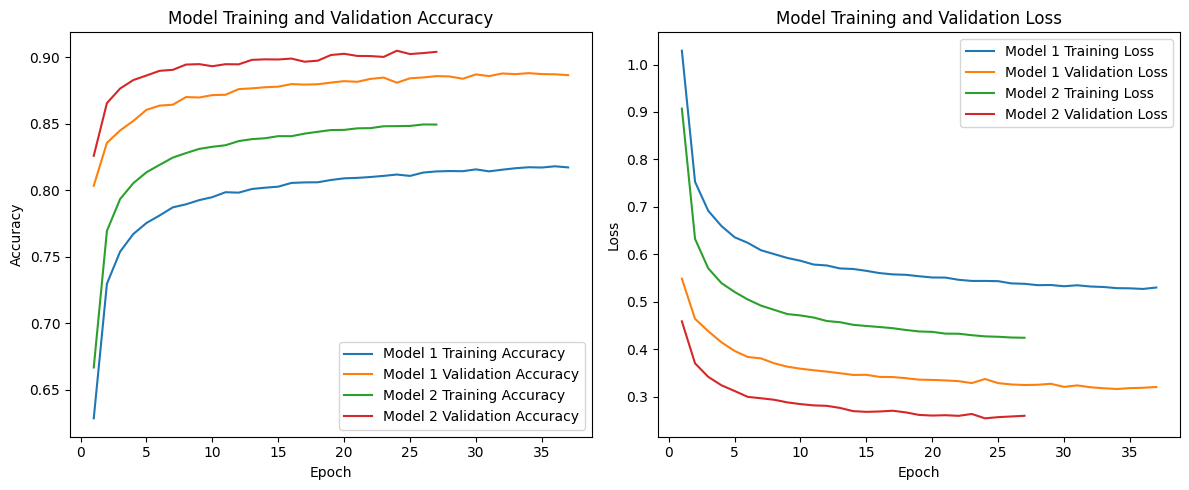

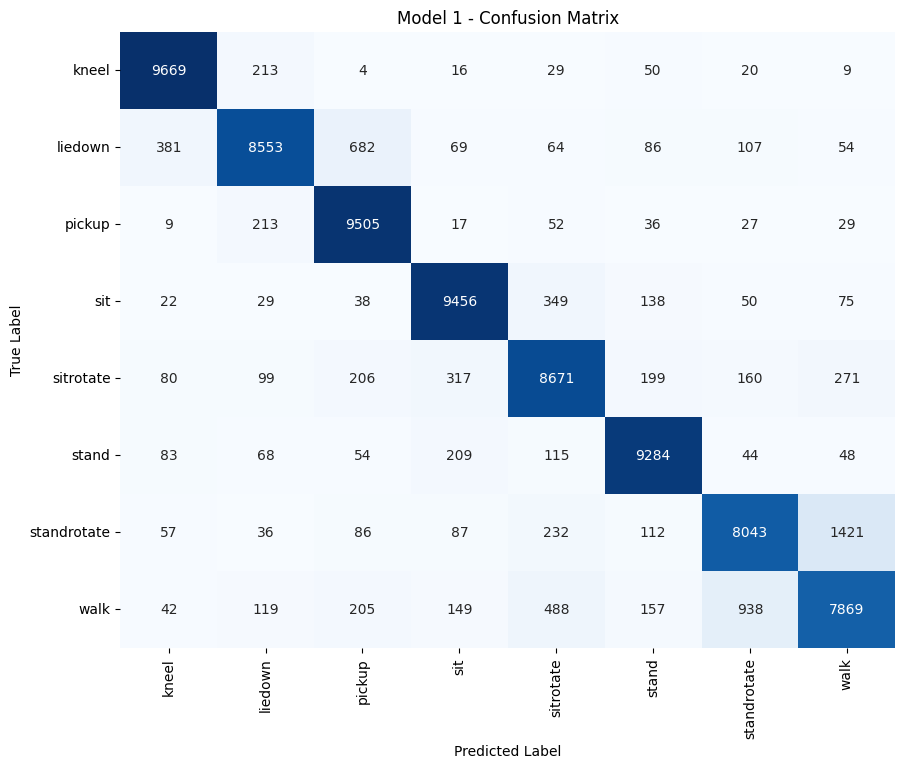

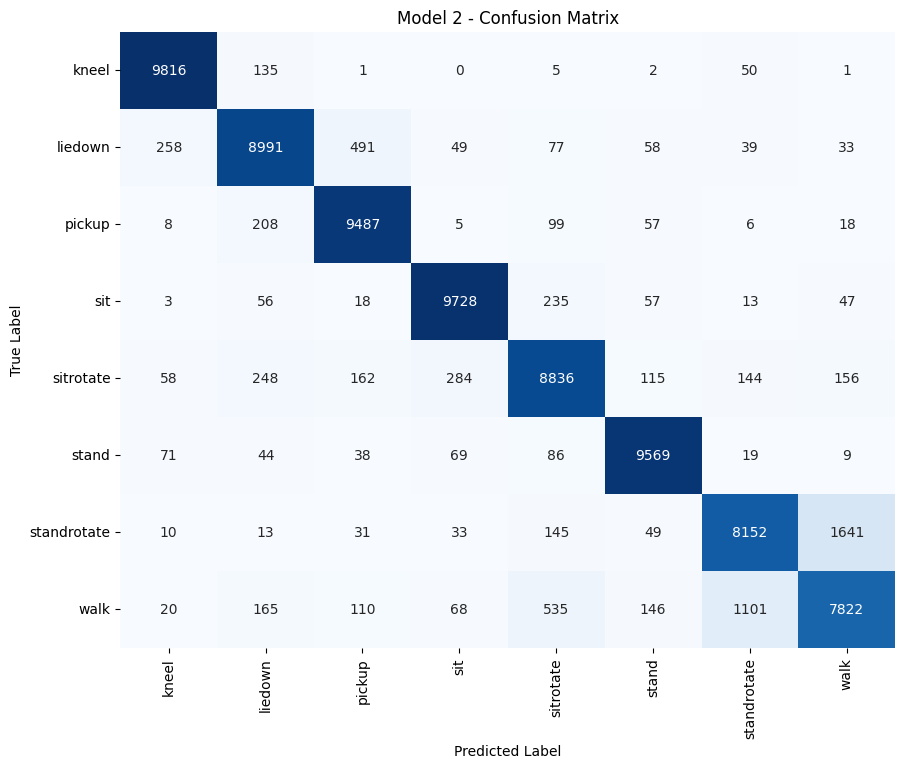

Comparison of Metrics and Training Time between Real and Complex models:
Accuracy: Complex model is 1.90% better than Real model
Precision: Complex model is 1.85% better than Real model
Recall: Complex model is 1.90% better than Real model
F1 Score: Complex model is 1.91% better than Real model
Training Time: Complex model takes 26.53% less time than Real model


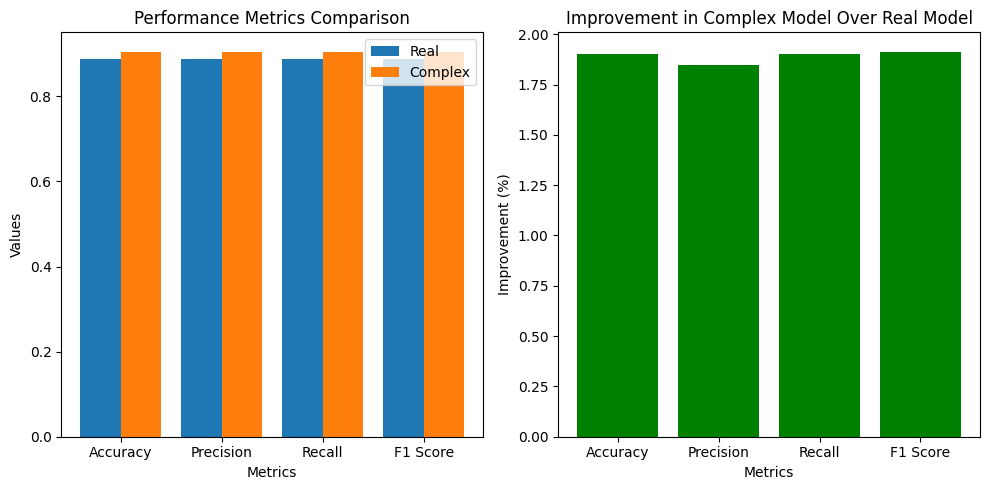

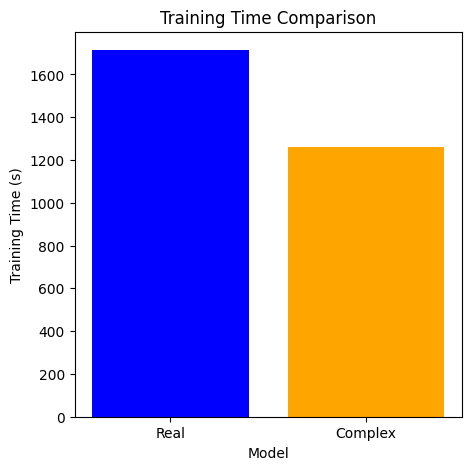

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(model1, model2, history1, history2, df1, df2, target_column_pattern, class_names):
    def evaluate_model(model, X_val, y_val):
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)
        y_val_true = np.argmax(y_val, axis=1)
        
        conf_matrix = confusion_matrix(y_val_true, y_val_pred)
        accuracy = accuracy_score(y_val_true, y_val_pred)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_val_true, y_val_pred, average='weighted')
        class_report = classification_report(y_val_true, y_val_pred)
        
        return accuracy, precision, recall, fscore, class_report, conf_matrix
    
    def plot_metrics(history1, history2, model1_name, model2_name):
        epochs1 = len(history1.history['accuracy'])
        epochs2 = len(history2.history['accuracy'])
        max_epochs = max(epochs1, epochs2)
        
        plt.figure(figsize=(12, 5))
        
        # Plot training accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs1 + 1), history1.history['accuracy'], label=f'{model1_name} Training Accuracy')
        plt.plot(range(1, epochs1 + 1), history1.history['val_accuracy'], label=f'{model1_name} Validation Accuracy')
        plt.plot(range(1, epochs2 + 1), history2.history['accuracy'], label=f'{model2_name} Training Accuracy')
        plt.plot(range(1, epochs2 + 1), history2.history['val_accuracy'], label=f'{model2_name} Validation Accuracy')
        plt.title('Model Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs1 + 1), history1.history['loss'], label=f'{model1_name} Training Loss')
        plt.plot(range(1, epochs1 + 1), history1.history['val_loss'], label=f'{model1_name} Validation Loss')
        plt.plot(range(1, epochs2 + 1), history2.history['loss'], label=f'{model2_name} Training Loss')
        plt.plot(range(1, epochs2 + 1), history2.history['val_loss'], label=f'{model2_name} Validation Loss')
        plt.title('Model Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(conf_matrix, class_names, model_name):
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'{model_name} - Confusion Matrix')
        ax.set_xticklabels(class_names, rotation=90)  # Rotate x labels for better readability
        ax.set_yticklabels(class_names, rotation=0)  # Keep y labels horizontal
        plt.show()
    
    # Identify feature columns and target columns for model 1
    feature_columns1 = [col for col in df1.columns if col.startswith('PC')]
    target_columns1 = df1.filter(regex=target_column_pattern).columns

    # Prepare data for model 1
    X1 = df1[feature_columns1].values.reshape(-1, len(feature_columns1), 1)  # Reshape data to fit Conv1D input
    y1 = df1[target_columns1].values  # One-hot encoded target columns

    # Split the data into training and validation sets for model 1
    X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
    
    # Identify feature columns and target columns for model 2
    feature_columns2 = [col for col in df2.columns if col.startswith('PC')]
    target_columns2 = df2.filter(regex=target_column_pattern).columns

    # Prepare data for model 2
    X2 = df2[feature_columns2].values.reshape(-1, len(feature_columns2), 1)  # Reshape data to fit Conv1D input
    y2 = df2[target_columns2].values  # One-hot encoded target columns

    # Split the data into training and validation sets for model 2
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
    
    # Evaluate both models
    accuracy1, precision1, recall1, fscore1, class_report1, conf_matrix1 = evaluate_model(model1, X_val1, y_val1)
    accuracy2, precision2, recall2, fscore2, class_report2, conf_matrix2 = evaluate_model(model2, X_val2, y_val2)
    
    # Print metrics for model 1
    print("Model 1 Metrics:")
    print("Accuracy:", accuracy1)
    print("Precision:", precision1)
    print("Recall:", recall1)
    print("F1 Score:", fscore1)
    print("\nClassification Report:\n", class_report1)
    
    # Print metrics for model 2
    print("Model 2 Metrics:")
    print("Accuracy:", accuracy2)
    print("Precision:", precision2)
    print("Recall:", recall2)
    print("F1 Score:", fscore2)
    print("\nClassification Report:\n", class_report2)
    
    # Plot metrics for both models side by side
    plot_metrics(history1, history2, "Model 1", "Model 2")
    
    # Plot confusion matrix for model 1
    plot_confusion_matrix(conf_matrix1, class_names, "Model 1")
    
    # Plot confusion matrix for model 2
    plot_confusion_matrix(conf_matrix2, class_names, "Model 2")
    
    return {
        'real_metrics': {
            'Accuracy': accuracy1,
            'Precision': precision1,
            'Recall': recall1,
            'F1 Score': fscore1
        },
        'complex_metrics': {
            'Accuracy': accuracy2,
            'Precision': precision2,
            'Recall': recall2,
            'F1 Score': fscore2
        }
    }

metrics = compare_models(model_real, model_complex, history_real, history_complex, df_pca_real, df_pca_complex, 'activity_', 
               ['kneel', 'liedown', 'pickup', 'sit', 'sitrotate', 'stand', 'standrotate', 'walk'])

Comparison of Metrics and Training Time between Real and Complex models:
Accuracy: Complex model is 1.90% better than Real model
Precision: Complex model is 1.85% better than Real model
Recall: Complex model is 1.90% better than Real model
F1 Score: Complex model is 1.91% better than Real model
Training Time: Complex model takes 26.53% less time than Real model


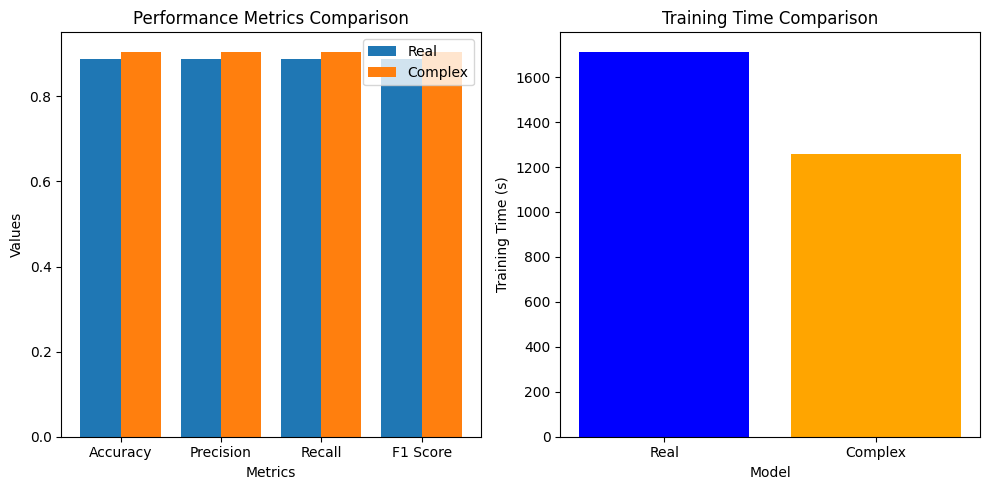

In [22]:
def compare_metrics(real_metrics, complex_metrics, real_train_time, complex_train_time):
    print("Comparison of Metrics and Training Time between Real and Complex models:")

    # Compare performance metrics
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for metric in metrics_names:
        real_metric_value = real_metrics[metric]
        complex_metric_value = complex_metrics[metric]
        improvement = ((complex_metric_value - real_metric_value) / real_metric_value) * 100
        print(f"{metric}: Complex model is {improvement:.2f}% better than Real model")

    # Compare training time
    improvement_time = ((complex_train_time - real_train_time) / real_train_time) * 100
    print(f"Training Time: Complex model takes {-improvement_time:.2f}% less time than Real model")
    
    # Plot performance metrics comparison
    x = range(len(metrics_names))
    real_values = [real_metrics[metric] for metric in metrics_names]
    complex_values = [complex_metrics[metric] for metric in metrics_names]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.bar(x, real_values, width=0.4, label='Real', align='center')
    plt.bar([i + 0.4 for i in x], complex_values, width=0.4, label='Complex', align='center')
    plt.xticks([i + 0.2 for i in x], metrics_names)
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance Metrics Comparison')
    plt.legend()

    # Plot training time comparison
    plt.subplot(1, 2, 2)
    plt.bar(['Real', 'Complex'], [real_train_time, complex_train_time], color=['blue', 'orange'])
    plt.xlabel('Model')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')

    plt.tight_layout()
    plt.show()

real_metrics = metrics['real_metrics']
complex_metrics = metrics['complex_metrics']

compare_metrics(real_metrics, complex_metrics, elapsed_time_real, elapsed_time_complex)